In [1]:
import numpy as np
from numpy import pi, sqrt, cos, sin, log, exp
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
from spectral_analysis_tools import *

col_dict = {'A': '#4E79A7', 'B': '#E15759','C': '#EDC948',
            'AB': '#B07AA1', 'AC': '#59A14F','BC': '#F28E2B'}

def col(s, lighten_amount = 1):
    return lighten_color(col_dict.get(s, 'k'), lighten_amount)

Text(0, 0.5, 'PSD amplitude (Hz$^2$/Hz)')

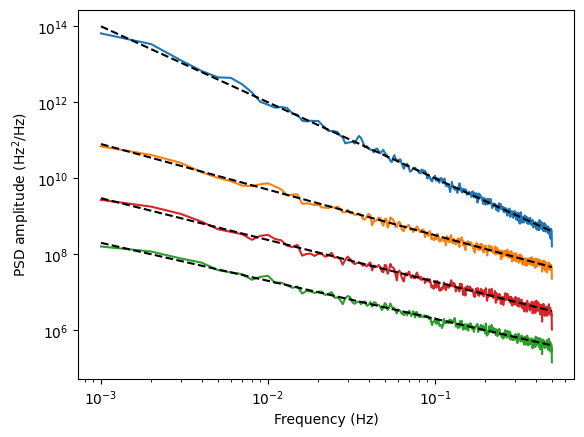

In [2]:
''' Simulate data to check the method compared to scipy Welch'''

M = 40 # Number of sets
N = 1000 # Length of each set
np.random.seed(731146)

dt=1 # Time step
freq_theory = np.fft.rfftfreq(N, d=dt) # Fourier frequency

Lambda_A = 1e8/(1e-37+freq_theory**2.) # A auto-PSD
Lambda_B = 2e7/(1e-37+freq_theory**1.2) # A auto-PSD
Lambda_C = 2e5/(1e-37+freq_theory**1.) # A auto-PSD

Lambdas_theory = [Lambda_A, Lambda_B, Lambda_C]

s_theory = [0.75 for i_f in range(len(freq_theory))] # BC normalized cross-PSD amplitude
phi_theory = [np.pi for fi in freq_theory] # BC normalized cross-PSD phase

mean_A = 1
mean_B = 1
mean_C = 1

A = np.zeros((M, N))
B = np.zeros((M, N))
C = np.zeros((M, N))

for Mi in range(M):
    A[Mi] = generate_autocorr(Lambda_A, mean_A,dt=dt)
    B[Mi], C[Mi] = generate_crosscorr(
            Lambda_B, Lambda_C, s_theory, phi_theory, mean_B, mean_C,dt=dt)

tr_dict = {'A': A,
           'B': B, 
           'C': C,
          }

ff, psda = sp.signal.welch(A,1/dt,nperseg=N)
ff, psdb = sp.signal.welch(B,1/dt,nperseg=N)
ff, psdc = sp.signal.welch(C,1/dt,nperseg=N)
ff, psdbc = sp.signal.csd(B,C,1/dt,nperseg=N)
psda = psda.mean(axis=0)
psdb = psdb.mean(axis=0)
psdc = psdc.mean(axis=0)
psdbc = psdbc.mean(axis=0)

plt.figure()
for xx in [psda,psdb,psdc,np.abs(psdbc)]:
    plt.plot(ff[1:],xx[1:]/2)
for xx in [Lambda_A,Lambda_B,Lambda_C,s_theory*np.sqrt(Lambda_B*Lambda_C)]:
    plt.plot(freq_theory[1:],xx[1:],'k--')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD amplitude (Hz$^2$/Hz)')


In [3]:
#-----Calculate clustered PSD-----

mode='mle' # Choose between 'mle', 'mele' and 'bar'
psd_mode = ['A;B;C'][0]

N_x=40

auto_corrs_clus = {}
for k, s in enumerate(psd_mode.split(';')):
    print(s)
    tr = tr_dict[s]
    dict_part = PSD_clus(tr, dt, N_x=N_x, N_y=800, tol=0.1, mode=mode, return_P=True)
    auto_corrs_clus.update({s:dict_part})

#-----Calculate clustered CSD-----

csd_mode = ['BC','AB;BC;AC'][0]

cross_corrs_clus = {}
for k, s in enumerate(csd_mode.split(';')):
    print(s)
    trA, trB = [tr_dict[s] for s in csd_mode.split(';')[k]]
    dict_part = CSD_clus(trA, trB, dt, return_P=True, tol=0.1, N_x=N_x, N_y=800, mode=mode)
    cross_corrs_clus.update({s:dict_part})

A
 Progress: [########################################] Calculating clustered auto corr.
B
 Progress: [########################################] Calculating clustered auto corr.
C
 Progress: [########################################] Calculating clustered auto corr.
BC
 Progress: [########################################] Clustered cross corr.


In [4]:
def plot_psd(data,key,confidence='dist',mode='Lambda',color=None,factor=1,bar_alpha=0.3,alpha=1,lighten_level=0.7,label=None,low_cut=None,high_cut=None,marker='.',ms=None,ls='-'):
    if len(key.split('-'))>1:key2=key.split('-')[1]+'-'+key.split('-')[0]
    else: key2=key
    if not(key in data) and not(key2 in data): raise Exception(key+' is not in the '+f'{cross_corrs_clus_u=}'.split('=')[0]+' dict')
    if color is None: 
        if key in col_dict: color = col(key)
        else: color = col(key2)
    if key in data: datakey = data[key]
    else: datakey = data[key2]
    if confidence=='dist':
        cmap = gradient_dict([lighten_color(color,lighten_level),lighten_color(color,lighten_level)],alpha_vec=[0,alpha])
        try:
            f_mesh, L_mesh = np.meshgrid((datakey['freq'][low_cut:high_cut]), (datakey[mode+'_vec'][low_cut:high_cut]*factor), indexing='ij')
            plt.pcolormesh((f_mesh),(L_mesh), datakey['P_'+mode][low_cut:high_cut],cmap=cmap,shading='nearest')
        except:
            for i,ii in enumerate(datakey['freq'][low_cut:high_cut][:-1]):
                f_mesh, L_mesh = np.meshgrid((np.linspace(datakey['freq'][low_cut:high_cut][i],datakey['freq'][low_cut:high_cut][i+1],2)), (datakey[mode+'_vec'][low_cut:high_cut][i]*factor), indexing='ij')
                plt.pcolormesh((f_mesh),(L_mesh), np.tile(datakey['P_'+mode][low_cut:high_cut][i],(2,1)),cmap=cmap,shading='nearest')
    
    if confidence=='bar':
        if mode == 'phif':
            for offset in [0,-2*pi,2*pi]:
                plt.fill_between(datakey['freq'][low_cut:high_cut], (datakey['phif_ci'][low_cut:high_cut,0]+offset)*factor,(datakey['phif_ci'][low_cut:high_cut,1]+offset)*factor,
                            color=color, alpha=bar_alpha, step='mid',lw=0)
        else: plt.fill_between(datakey['freq'][low_cut:high_cut], datakey[mode+'_ci'][low_cut:high_cut,0]*factor,datakey[mode+'_ci'][low_cut:high_cut,1]*factor,color=color, alpha=bar_alpha, step='mid',lw=0)
    plt.plot(datakey['freq'][low_cut:high_cut], datakey[mode][low_cut:high_cut]*factor, marker=marker,ms=ms,ls=ls, color = color,alpha=alpha,label=label)
    
def plot_style(psd_type='qubit',xscale='log',yscale=None,mode='Lambda',fontsize=12,xlim=None,ylim=None,legend=False,loc=1):
    if yscale is None:
        if mode == 'Lambda': yscale='log'
        else: yscale='linear'
    plt.xscale(xscale)
    plt.yscale(yscale)
    if mode=='Lambda':
        if psd_type=='sensor': 
            plt.ylabel(r'PSD ($\rm{mV}^2/\rm{Hz}$)',fontsize=fontsize)
        if psd_type=='qubit-sensor' or psd_type=='sensor-qubit':
            plt.ylabel(r'PSD ($\rm{Hz}\times\rm{mV}/\rm{Hz}$)',fontsize=fontsize)
        if psd_type=='qubit': plt.ylabel(r'PSD ($\rm{Hz}^2/\rm{Hz}$)',fontsize=fontsize)
    if mode=='sf':
        plt.ylabel(r'Correlation',fontsize=fontsize)
    if mode=='phif':
        plt.ylabel(r'Phase (rad)',fontsize=fontsize)
    plt.xlabel(r'Frequency ($\rm{Hz}$)', fontsize=fontsize)
    plt.xlim(xlim);
    plt.ylim(ylim);
    if legend: plt.legend(loc=loc);

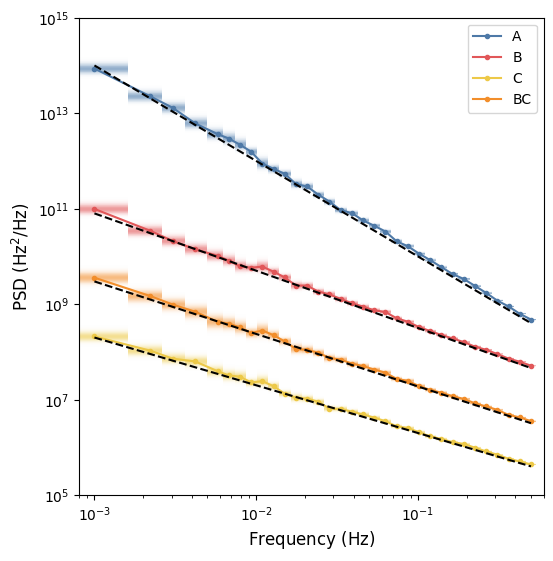

In [6]:
''' Plot with color gradient or error bars '''

xlim=(0.8e-3,6e-1)
confidence = 'dist' # Choose between 'bar' or 'dist'

plt.figure(figsize= (6, 6.2))

for k,s in enumerate(psd_mode.split(';')):
    plot_psd(auto_corrs_clus,s,confidence=confidence,factor=1,label=s,lighten_level=0.6)
for k,s in enumerate(csd_mode.split(';')):
    plot_psd(cross_corrs_clus,s,confidence=confidence,factor=1,label=s,lighten_level=0.6)
for xx in [Lambda_A,Lambda_B,Lambda_C,s_theory*np.sqrt(Lambda_B*Lambda_C)]:
    plt.plot(freq_theory[1:],xx[1:],'k--')
    
plot_style(xlim=xlim,ylim=(1e5,1e15))
plt.legend(loc='upper right')


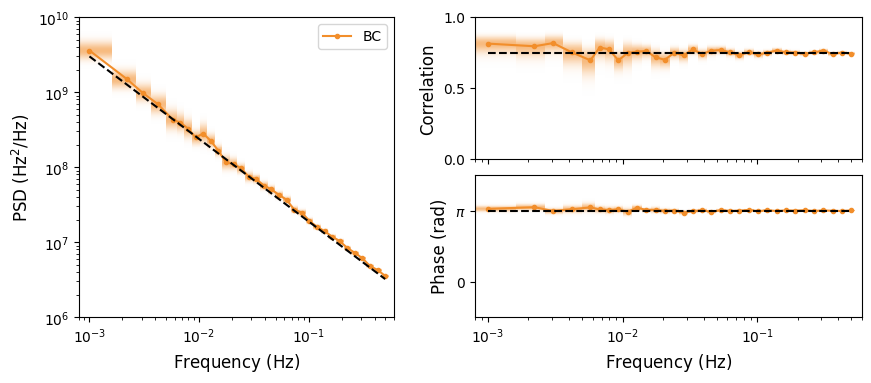

In [8]:
''' Plot cross-PSDs'''

xlim=(0.8e-3,6e-1)
confidence = 'dist' #'bar' or 'dist'

for k,s in enumerate(csd_mode.split(';')):
    
    fig = plt.figure(figsize=(9,4));
    ####----- Cross-PSD ----
    ax1 = fig.add_axes([0.11,0.15,0.35,0.75]) # row 0, col 0
    plot_psd(cross_corrs_clus,s,confidence=confidence,factor=1,label=s,lighten_level=0.6)
    plot_style(xlim=xlim,ylim=(1e6,1e10))
    ax1.plot(freq_theory[1:],(s_theory*np.sqrt(Lambda_B*Lambda_C))[1:],'k--')
    plt.legend(loc='upper right')

    ####----- Normalized Cross-PSD magnitude ----
    ax2 = fig.add_axes([0.55,0.545,0.43,0.355]) # row 0, col 1
    plot_psd(cross_corrs_clus,s,mode='sf',confidence=confidence,label=s,lighten_level=0.6,low_cut=None)
    ax2.plot(freq_theory[1:],s_theory[1:],'k--')
    plot_style(xlim=xlim,ylim=(0,0.5),mode='sf')
    ax2.set_yticks([0,0.5,1])
    ax2.set_xticklabels([])

    ####----- Cross-PSD phase ----
    ax3 = fig.add_axes([0.55,0.15,0.43,0.355]) 
    plot_psd(cross_corrs_clus,s,mode='phif',factor=1,confidence=confidence,label=s,lighten_level=0.6)
    ax3.plot(freq_theory[1:],phi_theory[1:],'k--')
    plot_style(xlim=xlim,ylim=(-0.5*pi,1.5*pi),mode='phif')
    ax3.set_yticks([0, pi])
    ax3.set_yticklabels(['0', r'$\pi$'])


In [9]:
#-----Calculate PSD-----

mode='mele' # Choose between 'mle', 'mele' and 'bar'
psd_mode = ['A;B;C'][0]

N_x=40

auto_corrs = {}
for k, s in enumerate(psd_mode.split(';')):
    print(s)
    tr = tr_dict[s]
    dict_part = PSD(tr, dt, tol=0.1,mode=mode, return_P=True)
    auto_corrs.update({s:dict_part})

#-----Calculate clustered CSD-----

csd_mode = ['BC','AB;BC;AC'][0]

cross_corrs = {}
for k, s in enumerate(csd_mode.split(';')):
    print(s)
    trA, trB = [tr_dict[s] for s in csd_mode.split(';')[k]]
    dict_part = CSD(trA, trB, dt, return_P=True, tol=0.1, mode=mode)
    cross_corrs.update({s:dict_part})

A
M = 40
 Progress: [########################################] Calculating auto corr.
B
M = 40
 Progress: [########################################] Calculating auto corr.
C
M = 40
 Progress: [########################################] Calculating auto corr.
BC
M = 40
 Progress: [########################################] Calculating cross corr.


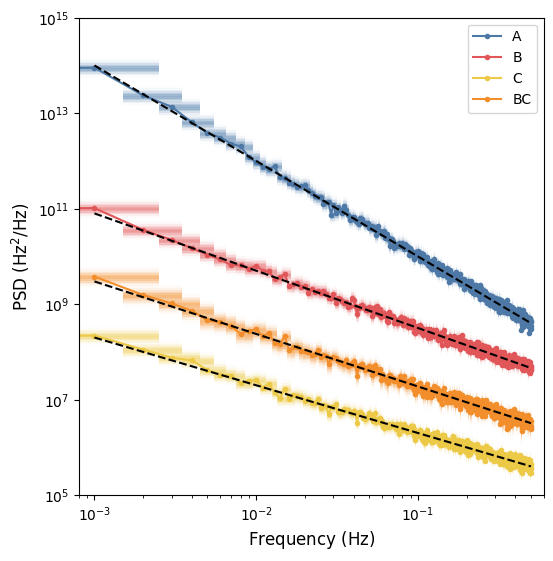

In [11]:
''' Plot with color gradient or error bars '''

xlim=(0.8e-3,6e-1)
confidence = 'dist' # Choose between 'bar' or 'dist'

plt.figure(figsize= (6, 6.2))

# plot_psd(auto_corrs,'C',confidence=confidence,factor=1,label=s,lighten_level=0.6)

for k,s in enumerate(psd_mode.split(';')):
    plot_psd(auto_corrs,s,confidence=confidence,factor=1,label=s,lighten_level=0.6)
for k,s in enumerate(csd_mode.split(';')):
    plot_psd(cross_corrs,s,confidence=confidence,factor=1,label=s,lighten_level=0.6)
for xx in [Lambda_A,Lambda_B,Lambda_C,s_theory*np.sqrt(Lambda_B*Lambda_C)]:
    plt.plot(freq_theory[1:],xx[1:],'k--')
    
plot_style(xlim=xlim,ylim=(1e5,1e15))
plt.legend(loc='upper right');


/var/folders/ks/5lwjf_5s5m78ctdrvk0g_kjr0000gn/T/ipykernel_87004/2476497836.py:14: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh((f_mesh),(L_mesh), datakey['P_'+mode][low_cut:high_cut],cmap=cmap,shading='nearest')


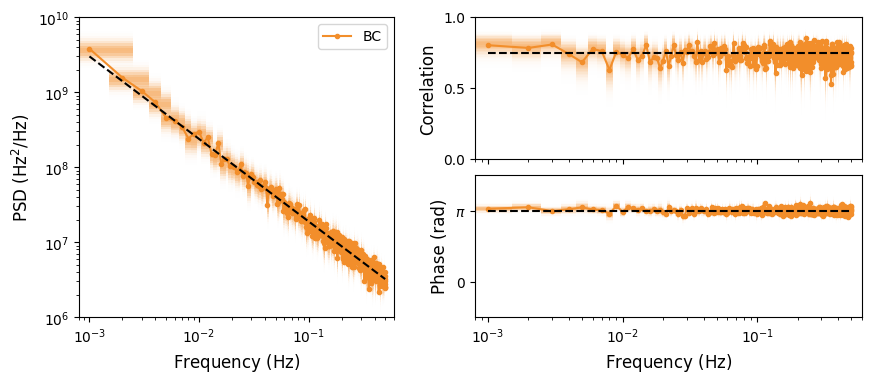

In [13]:
''' Plot cross-PSDs'''

xlim=(0.8e-3,6e-1)
confidence = 'dist' #'bar' or 'dist'

for k,s in enumerate(csd_mode.split(';')):
    
    fig = plt.figure(figsize=(9,4));
    ####----- Cross-PSD ----
    ax1 = fig.add_axes([0.11,0.15,0.35,0.75]) # row 0, col 0
    plot_psd(cross_corrs,s,confidence=confidence,factor=1,label=s,lighten_level=0.6)
    plot_style(xlim=xlim,ylim=(1e6,1e10))
    ax1.plot(freq_theory[1:],(s_theory*np.sqrt(Lambda_B*Lambda_C))[1:],'k--')
    plt.legend(loc='upper right')

    ####----- Normalized Cross-PSD magnitude ----
    ax2 = fig.add_axes([0.55,0.545,0.43,0.355]) # row 0, col 1
    plot_psd(cross_corrs,s,mode='sf',confidence=confidence,label=s,lighten_level=0.6,low_cut=None)
    ax2.plot(freq_theory[1:],s_theory[1:],'k--')
    plot_style(xlim=xlim,ylim=(0,0.5),mode='sf')
    ax2.set_yticks([0,0.5,1])
    ax2.set_xticklabels([])

    ####----- Cross-PSD phase ----
    ax3 = fig.add_axes([0.55,0.15,0.43,0.355]) 
    plot_psd(cross_corrs,s,mode='phif',factor=1,confidence=confidence,label=s,lighten_level=0.6)
    ax3.plot(freq_theory[1:],phi_theory[1:],'k--')
    plot_style(xlim=xlim,ylim=(-0.5*pi,1.5*pi),mode='phif')
    ax3.set_yticks([0, pi])
    ax3.set_yticklabels(['0', r'$\pi$'])
